In [1]:
import MLP_Olaf as ML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import seaborn as sns

In [2]:
%config IPCompleter.greedy=True

In [3]:
class MLP_new:
    def __init__(self, input_layer_len, output_layer_len, hidden_layers_len,
                 acti_funs,acti_funs_grad,cost_fun,cost_fun_grad,seed=123):
        
        np.random.seed(seed)
        
        self.acti_funs=acti_funs
        self.acti_funs_grad=acti_funs_grad
        
        self.cost_fun=cost_fun
        self.cost_fun_grad=cost_fun_grad
        
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.output_before =np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len))*2-1)
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1]))*2-1)
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1]))*2-1)
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((hidden_layers_len[i],1)))
            
        
        self.biases.append(np.zeros((output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
    
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer
        
        input_layer=input_layer.T
        
        if(memory):
            for i in range(len(self.weights)-1):
                
                self.hidden_layers[i]=self.weights[i].dot(input_layer)+self.biases[i]
                input_layer=self.acti_funs[i](self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.acti_funs[i](self.weights[i].dot(input_layer)+self.biases[i])
                
        
       
        output_layer=self.acti_funs[-1](self.weights[-1].dot(input_layer)+self.biases[-1])
        self.output_before=(self.weights[-1].dot(input_layer)+self.biases[-1]).T
        self.output_layer=output_layer.T
        
        return(output_layer.T)
        
    def train(self,train_input_layer,train_output_layer,max_epoch=2000,rate=0.1,beta=0,batch=1,stop=10**-6,RMSprop=False,
              L1=False,L2=False,eps=10**-8,alpha=0.01,validate=False,early_stop=3,test_input_layer=0,test_output_layer=0,return_error_list=True,Verbose=True):
        #creating batches
        lin=np.linspace(0,train_input_layer.shape[0],int(1/batch)+1).round().astype(int)
        #initiating errors
        output_layer=self.calculate(train_input_layer)
        error=self.cost_fun(train_output_layer,output_layer)
        #initiating early stopping
        warning=0
        if validate:
            output_layer=self.calculate(test_input_layer)
            error_test=self.cost_fun(test_output_layer,output_layer)
        
        print("start error "+str(error))
        #initiating old gradient list
        old_grad=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        old_grad_bias=[[0]*(len(lin)-1) for x in range(len(self.weights))]
        error_list=[error]
        
        
        for epoch in range(1,max_epoch+1):
            
            for b in range(len(lin)-1):

                input_layer=train_input_layer[lin[b]:lin[b+1]]
                output_layer=self.calculate(input_layer,memory=True)
                
                batch_size=output_layer.shape[0]
                errors=[[0]*len(self.weights) for x in range(batch_size)]

                for x in range(batch_size):
                    #all cost funs should be independent from size of vectors because we rescale them later
                    #last acti fun is used at output_layer so for classification it should be softmax and for regresion identity
                    errors[x][-1]=((self.cost_fun_grad(train_output_layer[lin[b]:lin[b+1]][x:x+1],output_layer[x:x+1]))*self.acti_funs_grad[-1](self.output_before[x:x+1])).T
                    for i in range(len(self.weights)-2,-1,-1): 
                        errors[x][i]=self.weights[i+1].T.dot(errors[x][i+1])*self.acti_funs_grad[i](self.hidden_layers[i][:,x:x+1])
                
                for l in range(1,len(self.weights)):
                    #we rescale by batch size here
                    #new_grad=np.clip(new_grad,-10**6,10**6) is used to prevent weights exploding
                    #we update grads beta here is momentum
                    if(RMSprop):
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        #print("hello")
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        #regularization
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        #updating gradients
                        old_grad[l][b]=beta*old_grad[l][b]+(1-beta)*new_grad**2
                        self.weights[l]=self.weights[l]-new_grad*(rate/(np.sqrt(old_grad[l][b])+eps))

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        old_grad_bias[l][b]=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias**2
                        self.biases[l]=self.biases[l]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[l][b])+eps))
                    else:
                        new_grad=sum([errors[x][l].dot(self.acti_funs[l-1](self.hidden_layers[l-1][:,x:x+1]).T) for x in range(batch_size)])/batch_size
                        #print("pepega")
                        new_grad=np.clip(new_grad,-10**6,10**6)
                        if L1:
                            new_grad+=alpha*np.sign(self.weights[l])#/batch_size
                        elif L2:
                            new_grad+=alpha*self.weights[l]#/batch_size
                        new_grad=beta*old_grad[l][b]+(1-beta)*new_grad
                        old_grad[l][b]=new_grad
                        self.weights[l]=self.weights[l]-new_grad*rate

                        new_grad_bias=sum([errors[x][l] for x in range(batch_size)])/batch_size
                        new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                        new_grad_bias=beta*old_grad_bias[l][b]+(1-beta)*new_grad_bias
                        old_grad_bias[l][b]=new_grad_bias
                        self.biases[l]=self.biases[l]-new_grad_bias*rate

                if(RMSprop):
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    old_grad[0][b]=beta*old_grad[0][b]+(1-beta)*new_grad**2
                    self.weights[0]=self.weights[0]-new_grad*(rate/(np.sqrt(old_grad[0][b])+eps))

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    old_grad_bias[0][b]=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias**2
                    self.biases[0]=self.biases[0]-new_grad_bias*(rate/(np.sqrt(old_grad_bias[0][b])+eps))
                else:
                    new_grad=sum([errors[x][0].dot((self.input_layer.T[:,x:x+1]).T) for x in range(batch_size)])/batch_size
                    new_grad=np.clip(new_grad,-10**6,10**6)
                    if L1:
                        new_grad+=alpha*np.sign(self.weights[0])#/batch_size
                    elif L2:
                        new_grad+=alpha*self.weights[0]#/batch_size
                    new_grad=beta*old_grad[0][b]+(1-beta)*new_grad
                    old_grad[0][b]=new_grad
                    self.weights[0]=self.weights[0]-new_grad*rate

                    new_grad_bias=sum([errors[x][0] for x in range(batch_size)])/batch_size
                    new_grad_bias=np.clip(new_grad_bias,-10**6,10**6)
                    new_grad_bias=beta*old_grad_bias[0][b]+(1-beta)*new_grad_bias
                    old_grad_bias[0][b]=new_grad_bias
                    self.biases[0]=self.biases[0]-new_grad_bias*rate


            output_layer=self.calculate(train_input_layer)
            new_error=self.cost_fun(train_output_layer,output_layer)
            
            #check stopping conditions if worse early_stop a row then stop
            if validate:
                output_layer=self.calculate(test_input_layer)
                new_error_test=self.cost_fun(test_output_layer,output_layer)
                if new_error_test>error_test:
                    if warning>=early_stop:
                        break
                    else:
                        error_test=new_error_test
                        warning+=1
                else:
                    error_test=new_error_test
                    warning=0
                
            if return_error_list:
                error_list.append(new_error)
            
            if(epoch % 500 == 0 and Verbose):
                print("epoch "+str(epoch))
                
            if new_error<=0:
                break
            
            if ((abs(new_error-error)/error)<stop).all():
                break

            error=new_error
        
        print("end in epoch "+str(epoch)+ " with error "+str(new_error))
        if return_error_list:
            return error_list
        else:
            return new_error

In [4]:
def softmax(z):
    e = np.exp(z)
    return e / np.sum(e, axis=0,keepdims=True)

In [5]:
def softmax_grad(s):
    s=softmax(s.T)
    return (s*(1-s)).T   

In [6]:
def ReLU(x):
    return x * (x > 0)

In [7]:
def ReLU_grad(x):
    return 1. * (x > 0)

In [8]:
def tanh(z):
    e = np.exp(2*z)
    return 1-2/(e+1)

In [9]:
def tanh_grad(z):
    return 1-tanh(z)**2

In [10]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

In [11]:
def MSE_grad(Y,Y_hat):
     return Y_hat-Y

In [12]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [13]:
def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [14]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = abs(np.sum(targets*np.log(predictions)))
    return ce


In [15]:
def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [16]:
def identity(x):
    return x

In [17]:
def identity_grad(x):
    return 1

In [18]:
test = np.loadtxt("Project 1 datasets/classification/data.simple.train.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [19]:
test = np.loadtxt("Project 1 datasets/classification/data.simple.test.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

[Text(0.5, 1.0, 'Test data')]

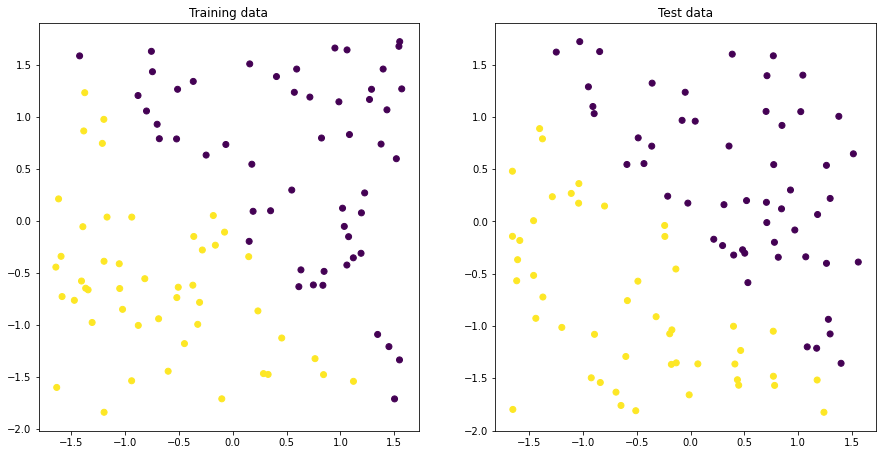

In [20]:
fig=plt.figure(figsize=(15,7.5))
ax=fig.add_subplot(121)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Training data")

ax1=fig.add_subplot(122)
ax1.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax1.set(title="Test data")

In [21]:
L=[10,10,10]
mlp_test=ML.MLP_new(2,2,L,[ML.sigmoid]*len(L)+[ML.softmax],[ML.sigmoid_grad]*len(L)+[ML.softmax_grad],ML.cross_entropy,ML.cross_entropy_grad)
er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=300,Verbose=False)
output_layer=mlp_test.calculate(train_input_layer)
ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
output_layer=mlp_test.calculate(test_input_layer)
ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
output_layer=mlp_test.calculate(train_input_layer)
score_train=ML.cross_entropy(train_output_layer,output_layer)
output_layer=mlp_test.calculate(test_input_layer)
score_test=ML.cross_entropy(test_output_layer,output_layer)

start error 68.89293198509968
end in epoch 300 with error 25.106589866205436


[Text(0.5, 1.0, 'Test data')]

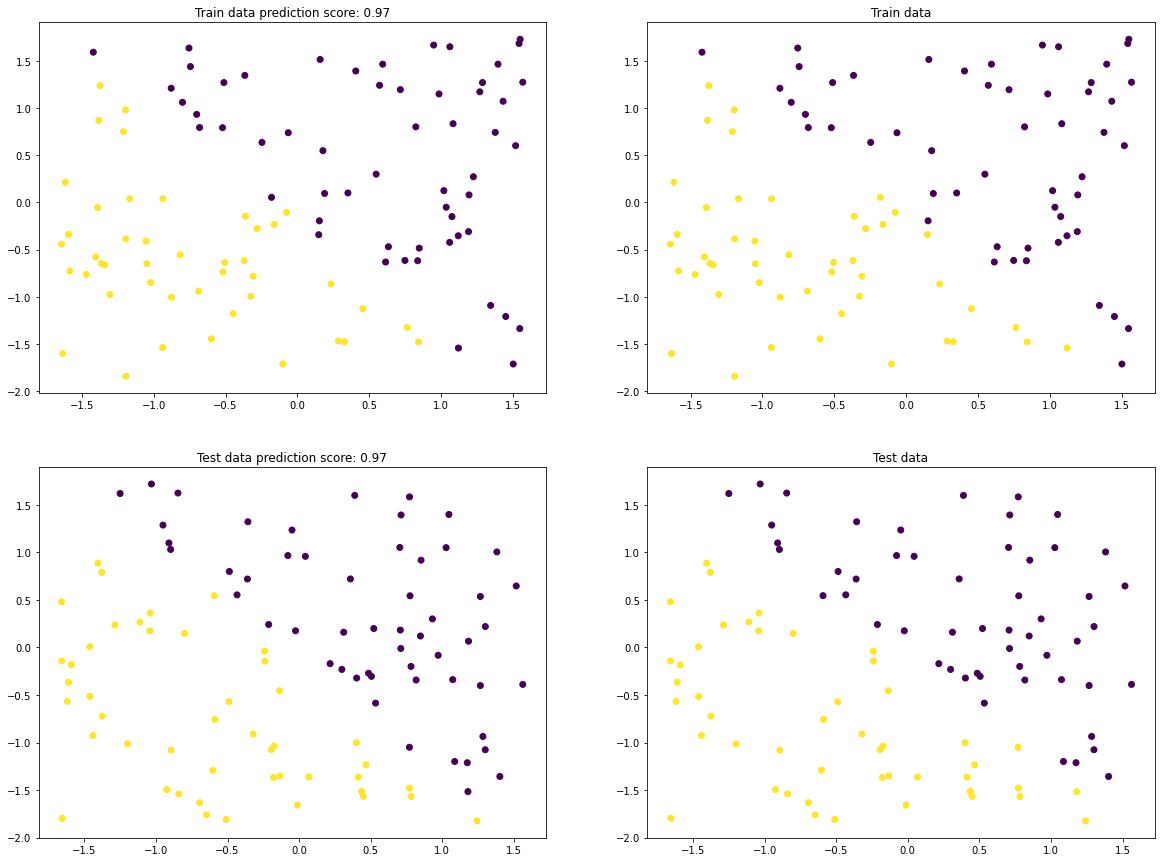

In [23]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(221)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax1=fig.add_subplot(222)
ax1.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax1.set(title="Train data")


output_layer=mlp_test.calculate(test_input_layer)

ax2=fig.add_subplot(223)
ax2.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax2.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax3=fig.add_subplot(224)
ax3.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax3.set(title="Test data")

In [24]:
test = np.loadtxt("Project 1 datasets/classification/data.three_gauss.train.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [25]:
test = np.loadtxt("Project 1 datasets/classification/data.three_gauss.test.100.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

[Text(0.5, 1.0, 'Test data')]

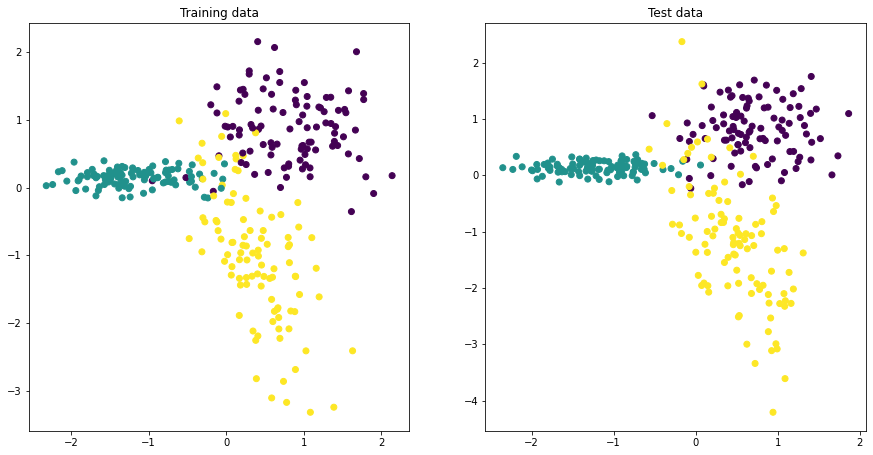

In [26]:
fig=plt.figure(figsize=(15,7.5))
ax=fig.add_subplot(121)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Training data")

ax1=fig.add_subplot(122)
ax1.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax1.set(title="Test data")

In [27]:
L=[10,10,10]
mlp_test=ML.MLP_new(2,3,L,[ML.sigmoid]*len(L)+[ML.softmax],[ML.sigmoid_grad]*len(L)+[ML.softmax_grad],ML.cross_entropy,ML.cross_entropy_grad)
er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=300,Verbose=False)
output_layer=mlp_test.calculate(train_input_layer)
ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
output_layer=mlp_test.calculate(test_input_layer)
ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
output_layer=mlp_test.calculate(train_input_layer)
score_train=ML.cross_entropy(train_output_layer,output_layer)
output_layer=mlp_test.calculate(test_input_layer)
score_test=ML.cross_entropy(test_output_layer,output_layer)

start error 324.2446302001388
end in epoch 300 with error 142.50971529847715


[Text(0.5, 1.0, 'Test data')]

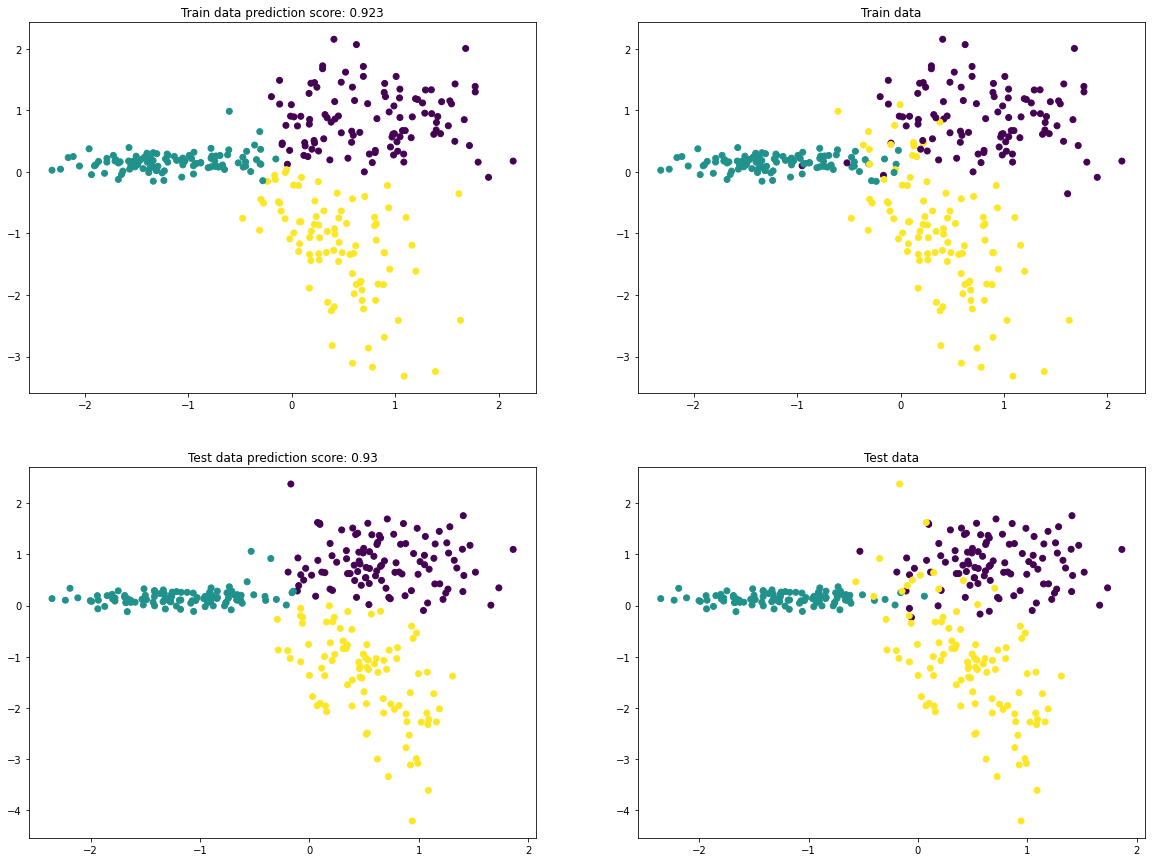

In [28]:
output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(221)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax1=fig.add_subplot(222)
ax1.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax1.set(title="Train data")


output_layer=mlp_test.calculate(test_input_layer)

ax2=fig.add_subplot(223)
ax2.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax2.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax3=fig.add_subplot(224)
ax3.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax3.set(title="Test data")